# Load libraries

In [17]:
import pandas as pd
import numpy  as np
import string 
import re
import itertools
import matplotlib.pyplot as plt
import seaborn as sns
from nltk.corpus import stopwords 
from nltk.tokenize import word_tokenize
from nltk.stem.porter import PorterStemmer
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer

# Data import

In [8]:
pd.set_option('max_colwidth', None) 
df = pd.read_csv("~/Downloads/banData/MeTooHate.csv", nrows = 10000)
#df.head()
df.category.value_counts()

0    8582
1    1418
Name: category, dtype: int64

# Sample data

## Annotation rule

- 0: neutral  content or positive sentiment
- 1: negative sentiment or negative fact but no abusive wording
- 2: Abusive/ hate language

In [9]:
df_mini = df[df["category"]==1].iloc[0:101].head(100)
df_mini.reset_index(inplace =True)

label=[2, 2, 1,  1, 1, 1,  1, 2,  1, 0,  2,   1,  1,  1,  1,
  1, 1, 1,0,2,1,    1,    1,    1,    1,   2,     1,    2,    0,    1,
  0,1,2, 0,1,2, 0,1,1,0, 
  1,0,1,0,1,1,1,2,1,2,
  2,2,2,0,1, 0,2,1,1,1,
  1,1,1,0,1,2,1,0,1,0,
  2,  1,1,   2, 1,2,   1, 1,0,1,1 ,
  1,   2,   2,   0,   2,   0,   1,   1,   1,   1,   1,   1,   0,
   1,2,1, 0, 1,1]
df_mini["label"] = label

tmp = df[df["category"]==0].iloc[0:39]
tmp.reset_index(inplace =True)
tmp["label"] = 0
tmp.index = pd.Series(np.array(tmp.index)+100)

df_mini = pd.concat([df_mini, tmp],  axis=0 )
df_mini.drop(columns = ["status_id",'created_at', 'location'], inplace = True)
df_mini.reset_index(inplace  = True)

df_mini.drop_duplicates(inplace = True)
df_mini.label.value_counts()

1    58
0    58
2    23
Name: label, dtype: int64

## Compare features between labels

In [10]:
df_mini.describe()

,level_0,index,favorite_count,retweet_count,followers_count,friends_count,statuses_count,category,label
count,139.000000,139.000000,139.000000,139.000000,139.000000,139.000000,139.000000,139.000000,139.000000
mean,69.000000,277.230216,6.129496,1.582734,4651.712230,2342.258993,38723.151079,0.719424,0.748201
std,40.269923,246.117985,25.867789,6.204135,17843.557261,6108.417808,84759.515571,0.450905,0.723253
min,0.000000,0.000000,0.000000,0.000000,1.000000,19.000000,9.000000,0.000000,0.000000
25%,34.500000,34.500000,0.000000,0.000000,194.500000,298.000000,2924.000000,0.000000,0.000000
50%,69.000000,233.000000,0.000000,0.000000,718.000000,966.000000,12715.000000,1.000000,1.000000
75%,103.500000,515.000000,2.000000,1.000000,2660.000000,2401.000000,36861.500000,1.000000,1.000000
max,138.000000,729.000000,245.000000,53.000000,173338.000000,67661.000000,666916.000000,1.000000,2.000000


In [11]:
drop_cols = ["level_0","index","category"]
df_mini.drop(columns = drop_cols, inplace = True)
df_mini.head()

,text,favorite_count,retweet_count,followers_count,friends_count,statuses_count,label
0,"Yep just like triffeling women weaponized their poon!! Wonder if Kamala Harris ever extorted Willy Brown after throwing the poon on him, oh yeh, that how she got her first job me too is a JOKE!",1,0,3573,3732,38361,2
1,"Save it for Fox Fake News—watched by racists, bigots &amp; other women-hating sexists like yourself. GOP is the party of Putin &amp; the party of Hate—besides women, GOP hates all POC, immigrants, and all ppl not straight. You’re the party of the entitled lying whiny white men.",0,0,718,1648,16113,2
2,"As a white male in this era I'm just scared that if I decide to rape or sexually assault a woman, it can be used against me years later. How am I supposed to ask a girl out?!",0,0,387,203,1670,1
3,I heard that received some Shush/Slush money to settle rape charges by her aide who said she just could not remember where or when. . .,0,0,1,28,489,1
4,"If she hasn't, it's because of people like you shaming her! How dare you tell her how she is or should be feeling! That is why I HATE the movement. Along with all of the other movements! You rape these people to further a political objective! You are despicable!",0,0,111,224,1719,1


In [12]:
df_mini.groupby('label').mean()

,favorite_count,retweet_count,followers_count,friends_count,statuses_count
label,,,,,
0,9.086207,2.137931,4081.862069,2106.137931,40685.172414
1,4.551724,1.362069,4752.534483,1871.431034,25573.758621
2,2.652174,0.739130,5834.478261,4125.000000,66934.782609


In [13]:
df_mini.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 139 entries, 0 to 138
Data columns (total 7 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   text             139 non-null    object
 1   favorite_count   139 non-null    int64 
 2   retweet_count    139 non-null    int64 
 3   followers_count  139 non-null    int64 
 4   friends_count    139 non-null    int64 
 5   statuses_count   139 non-null    int64 
 6   label            139 non-null    int64 
dtypes: int64(6), object(1)
memory usage: 8.7+ KB


In [14]:
df_mini_num = df_mini.select_dtypes(include="int64")
df_mini_num

,favorite_count,retweet_count,followers_count,friends_count,statuses_count,label
0,1,0,3573,3732,38361,2
1,0,0,718,1648,16113,2
2,0,0,387,203,1670,1
3,0,0,1,28,489,1
4,0,0,111,224,1719,1
...,...,...,...,...,...,...
134,1,0,1070,1710,24579,0
135,0,0,909,869,42870,0
136,0,0,3164,4995,9278,0
137,0,0,245,588,12535,0


In [42]:
list(range(3,6))

[3, 4, 5]

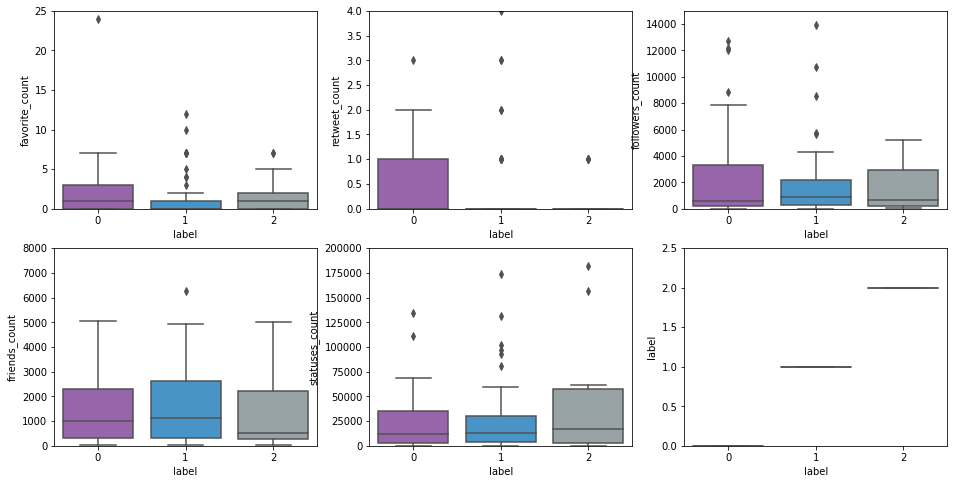

In [56]:
fig, axs = plt.subplots(2, 3, figsize=(16,8))  # axs is a (1,2) nd-array
ylims = [25,4,15000,8000,200000,2.5]
for i in range(6):
    if i <3:
        name = df_mini_num.columns[i]
        sns.boxplot(data=df_mini, x = 'label', y = name, ax = axs[0,i])
        axs[0,i].set(ylim=(0,ylims[i]))
    elif  i >= 3:
        name = df_mini_num.columns[i]
        sns.boxplot(data=df_mini, x = 'label', y = name, ax = axs[1,i-3]) 
        axs[1,i-3].set(ylim=(0,ylims[i]))

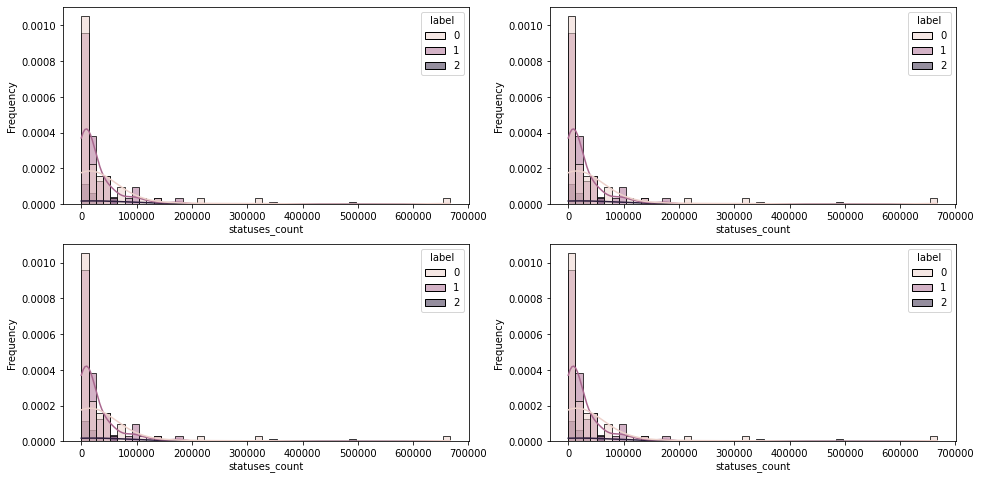

In [68]:
fig, axs = plt.subplots(2, 2, figsize=(16,8))  # axs is a (1,2) nd-array
data = df_mini_num.drop(columns = "retweet_count")
for i in range(4):
    if i < 2:
        name = data.columns[i]
        sns.histplot(data=data, x=data[], hue='label', 
                     stat = "frequency", kde = True, ax = axs[0,i]);

    elif  i >= 2:
        name = data.columns[i]
        sns.histplot(data=data, x='statuses_count', hue='label', 
                     stat = "frequency", kde = True, ax = axs[1,i-3]);

In [66]:
list(range(4))

[0, 1, 2, 3]

,favorite_count,followers_count,friends_count,statuses_count,label
0,1,3573,3732,38361,2
1,0,718,1648,16113,2
2,0,387,203,1670,1
3,0,1,28,489,1
4,0,111,224,1719,1
...,...,...,...,...,...
134,1,1070,1710,24579,0
135,0,909,869,42870,0
136,0,3164,4995,9278,0
137,0,245,588,12535,0


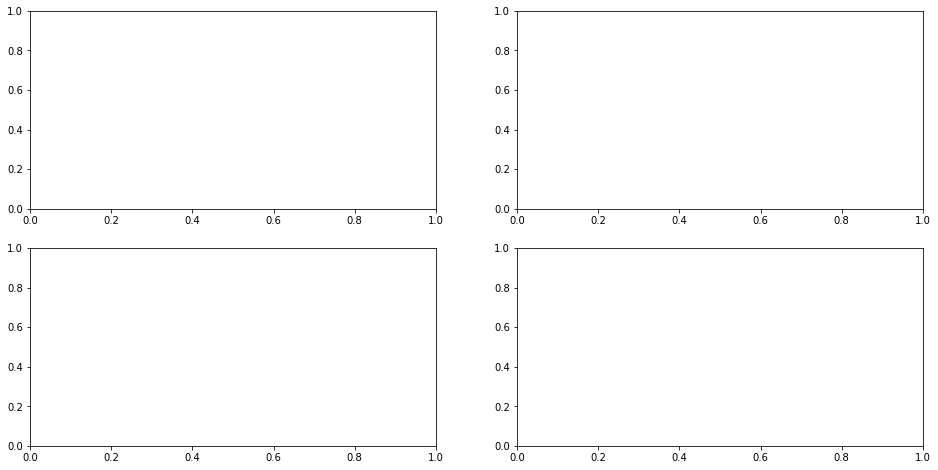

In [64]:
fig, axs = plt.subplots(2, 2, figsize=(16,8))  # axs is a (1,2) nd-array


# Litterature & github account

- label propagation:  https://towardsdatascience.com/semi-supervised-learning-how-to-assign-labels-with-label-propagation-algorithm-9f1683f4d0eb
- Lexicon of abusive words: https://github.com/uds-lsv/lexicon-of-abusive-words     
- Deep learning and clustering

# Alternative modeling plans

 - Manually relabel 2%-5% of tweets in category 1 (hate speech)
 - Apply label propagation algo to label the remaining tweets
 - All tweets labeled,  proceed with classification/DL model

# Data preprocessing



## Data cleaning

In [4]:
import nltk
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('omw-1.4')

[nltk_data] Downloading package stopwords to /home/mimi/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /home/mimi/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /home/mimi/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /home/mimi/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


True

In [ ]:
text = hate_text.iloc[59]

# lowercase
text = text.lower() 

# remove numbers
text = ''.join(word for word in text if not word.isdigit())

# punctuation
#string.punctuation
for punctuation in string.punctuation:
    text = text.replace(punctuation, '') 
    
# stopwords
stop_words = set(stopwords.words('english')) 

word_tokens = word_tokenize(data) 
  
text = [w for w in word_tokens if not w in stop_words] 
  
text


In [ ]:
# tokenizing - transform to list
word_tokens = word_tokenize(text) 
text = [w for w in word_tokens if not w in stop_words] 
text

## Lemantizing

In [ ]:
# Stemming or Lemmatizing- finding root word
# stemmer = PorterStemmer()
# stemmed = [stemmer.stem(word) for word in text]
lemmatizer = WordNetLemmatizer()
lemmatized = [lemmatizer.lemmatize(word) for word in text]
text = lemmatized
lemmatized


## Vectorizing

In [ ]:
# text numerical ----> representation

## Bag of words: counting ocuurences of each word (mx with word in col)
vectorizer = CountVectorizer()
X = vectorizer.fit_transform(text)
X.toarray()   
#vectorizer.get_feature_names()  
#pd.DataFrame(X.toarray(),columns = vectorizer.get_feature_names())  

In [ ]:
## Tf-Idf: Term Frequency - Inverse Document Frequency --> importance of word in document--> frequency
# pros: - frequency robust to document length
#       - measures importance
# cons: doesn't capture context

# texts = ['i love football',
#          'football is a game i love',
#         'football football football']

tf_idf_vectorizer = TfidfVectorizer()
X = tf_idf_vectorizer.fit_transform(text)
#X.toarray()
#pd.DataFrame(X.toarray(),columns = tf_idf_vectorizer.get_feature_names())

In [ ]:
# Key paramters BOW and Td-Idf :
# max_df = exclude "corpus specific stopwords", most freq words
# min_df = exclude words that are very infrequent in the dataset
# max_features = specify the number of features to keep when vectorizing, useful to reduce the dimension of the data

In [ ]:
### N-grams: Instead of considering individual words, 
#N-grams consists of considering word sequences. 
#This representation captures context. N is the number of words to be consiered as a one
texts =  [
         'i do not love football',
         'i love football not basketball']
tf_idf_vectorizer = TfidfVectorizer(ngram_range = (2,2))

X = tf_idf_vectorizer.fit_transform(texts)

X.toarray()

pd.DataFrame(X.toarray(),columns = tf_idf_vectorizer.get_feature_names())

# Test label propagation on minimal data

In [ ]:
! pip install plotly

In [ ]:
# Visualization
import plotly.express as px # for data visualization
import plotly.graph_objects as go # for data visualization
import matplotlib.pyplot as plt # for displaying confusion matrix

# Skleran
from sklearn.metrics import classification_report # for model evaluation metrics
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay # for showing confusion matrix
from sklearn.preprocessing import MinMaxScaler # for feature scaling
from sklearn.semi_supervised import LabelPropagation # for assigning labels to unlabeled data


## Data preprocessing

In [ ]:
# lowercase
text = text.lower() 

# remove numbers
text = ''.join(word for word in text if not word.isdigit())

# punctuation
#string.punctuation
for punctuation in string.punctuation:
    text = text.replace(punctuation, '') 
    
# stopwords
stop_words = set(stopwords.words('english'))

lemmatizer = WordNetLemmatizer()
lemmatized = [lemmatizer.lemmatize(word) for word in text]
text = lemmatized
lemmatized
tf_idf_vectorizer = TfidfVectorizer()
X = tf_idf_vectorizer.fit_transform(text)
#X.toarray()
#pd.DataFrame(X.toarray(),columns = tf_idf_vectorizer.get_feature_names())

# External abusive words list


In [ ]:
abusive_words_df = pd.read_csv('../raw_data/abusive_words_list.txt', delimiter = "\t").iloc[:,0:2]
abusive_words_df.columns = ["word", "neg_polarity"]
word2 = [str(x).split("_")[0] for x in abusive_words_df.word]
word2 = pd.Series(word2)
word2
abusive_words_df["word2"] = word2
abusive_words_df

word3 = pd.DataFrame(abusive_words_df["word2"].unique())
len(word3)
#'../raw_data/abusive_words_list.txt'
word3.to_csv('../project_BAN/data/abusive_words.txt',header="words", index=None, sep=' ', mode='a')


# Useful notes

imoji heart in negative comment 
Because is true and powerful (thanks, ❤️), I'm unearthing so much of my past. I just remembered that time a platonic male friend came to my house with a fish bat, repeatedly brandishing it in a threatening manner, and how calm I had to remain to get him ou

## Some features are:

- Vocabulary Richness
- Number of words per tweet
- punctuation/Character ratio
- emoji/Character ratio
- Contains abusive words
- Contains Words in Capital letters

In [ ]:
def vocab_richness(text):
    tokens = word_tokenize(text)
    total_length = len(tokens)
    unique_words = set(tokens)
    unique_word_length = len(unique_words)
    return unique_word_length/total_length

vocab_richness = df_mini.text.apply(vocab_richness)

vocab_richness

## Machine learning models
- Naive base fro classification
- LatentDirichletAllocation for clustering

## Deep learning model

https://kitt.lewagon.com/camps/773/lectures/content/06-DL_05-Natural-Language-Processing.html
    
X.shape = (n_sentences, max_sentence_length, embedding_dim)

steps:
    - tokenize text: tf.keras.preprocessing.text.Tokenizer
    - embedding layer (creating vector representation of each word): https://www.tensorflow.org/api_docs/python/tf/keras/layers/Embedding
                - custome embedding : can be done but computationally intensive
                - independent embedding woth Word2vec (Gensim) --- transfer learning
                
Powerful embedding that is very fast and easy to train!

✅ you give it a list of sentences
✅ it automatically learns a representation - an embedding - for each word it was trained on!

## Doc on twitter API

https://developer.twitter.com/en/docs/twitter-api/v1/data-dictionary/object-model/user

# extras

In [343]:
def create_filter_mask(df, text ,_filter,_filter_name = ""): 
    """
       df: dataframe
       text: name of the column containing text, on which filter is applied
       _filter : list, filter to be applied
       _filter_name: optional, suffix for the new column to be created
    """
    delete_row = [] # empty list to populate true/false
    for i in range(df.shape[0]):
        
        # Define temporary variable 
        tmp = df[f'text'].iloc[i]
        tmp_tokenize = re.split('\s+', tmp) 

        # Define intersection/common elements with _filter
        int = set.intersection(set(tmp_tokenize), set(filtre1))
        delete_row.append(len(int)!=0) 
        
        # Create a new column in df
    df[f'delete_row_{_filter_name}'] = delete_row
    return df


In [344]:
def apply_filter(df, filterBy, remove_or_relabel = True):
    """
       df: dataframe, an output of create_filter_mask(df, text ,_filter,_filter_name = "")
       filterBy:  column name to use for filtering. Coumn has to be boolean
       remove_or_relabel: if True, deletes rows where  filterBy are True and returns subset of original df
       If False, no rows are deleted but a new label column is added. Label is set to 2 for 
       rows not passing the filter, NaN for the rest.
       
    """
    
    
    if remove_or_relabel == True:
        new_df = df[df[f'{filterBy}']== False]
        new_df.drop(columns = f'{filterBy}', inplace = True)

    else :
        new_df = df.copy()
        new_df["label"] = np.nan
        new_df.loc[new_df[f'{filterBy}']== True, "label"] = 2
        new_df.drop(columns = f'{filterBy}', inplace = True)
    return new_df
    
        

In [8]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
X, y = pd.DataFrame(np.arange(10).reshape((5, 2))), pd.Series(range(5))
X

,0,1
0,0,1
1,2,3
2,4,5
3,6,7
4,8,9


In [9]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

In [10]:
X_train

,0,1
2,4,5
0,0,1
3,6,7


In [11]:
y_train

2    2
0    0
3    3
dtype: int64